# Geospatial Data Analysis I 

## Sensitivity Analysis - Solution

### Exercise 1: Contribution-to-Variance

As an example for simple sensitivity analysis we are going to use the model and the uncertainty analysis from the last exercise. So, first copy the script with the MC simulation into this notebook, so you can use to the input and output data for the following sensitivity analysis. 

0.00019348986732329977 0.21911373209146104


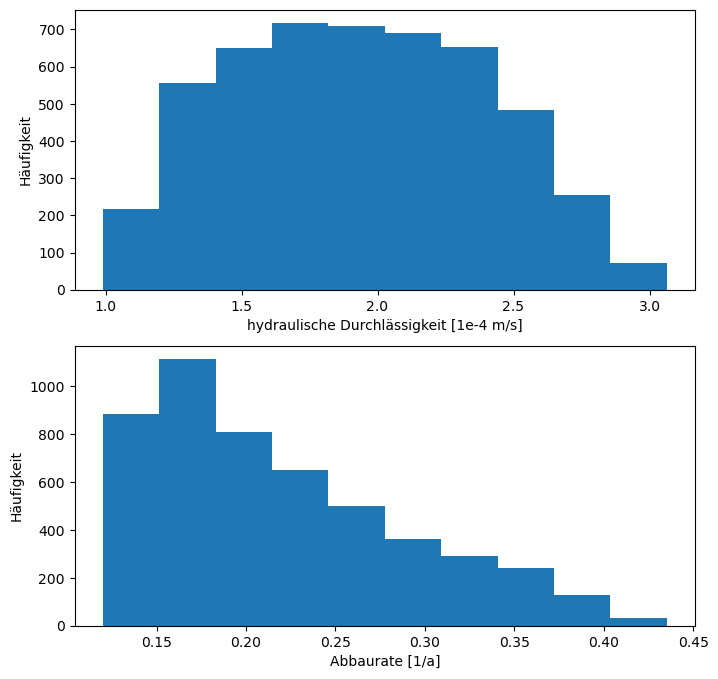

In [1]:
# Monte-Carlo Simulation for quantifiying degradation of o-xylene

# importing the required Python packages
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

# setting the number of MC simulations / iterations 
n = 5000 # number of MC simulations 

# generating random values for the input parameters
# in accordance to the probabality density functions given in the paper

# isotope shift delta 13C [o/oo], truncated to (3.8, 4.8)
a, b = (3.8 - 4.3) / 0.7, (4.8 - 4.3) / 0.7
deltaC = truncnorm.rvs(a, b, 4.3, 0.7, size=n)

# isotope enrichment factor epsilon [-]
epsilon = np.random.uniform(-3.2, -1.1, n)

# distance [m]
s = np.random.uniform(415, 423, n)

# effective porosity [-], trunctaed to (0.12, 0.30)
a, b = (0.12 - 0.21) / 0.09, (0.3 - 0.21) / 0.09
neff = truncnorm.rvs(a, b, 0.21, 0.09, size=n)

# time, truncated to (3e8, 3.3e8)
a, b = (3e8 - 3.15e8) / 1.6e6, (3.3e8 - 3.15e8) / 1.6e6
t = truncnorm.rvs(a, b, 3.15e8, 1.6e6, size=n)

# hydraulic gradient [-]
grad = np.random.uniform(1.3e-3, 1.6e-3, n)

# analytical modelling 
kf = (s*neff)/(t*grad)
lambda_rate = -(deltaC*kf*grad)/(epsilon*s*neff)

lambda_rate = lambda_rate*3600*24*365  # to get values as [1/a]

# printing mean values for hydraulic conductivity and degradation rate
print(kf.mean(), lambda_rate.mean())

# visualising the generated output values for hydraulic conductivity and degradation rate
# in two seperate histogram plots 

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(2,1,1)
kf_neu = kf*10000
plt.hist(kf_neu)
plt.ylabel("Häufigkeit")
plt.xlabel("hydraulische Durchlässigkeit [1e-4 m/s]")

ax1 = fig.add_subplot(2,1,2)
plt.hist(lambda_rate)
plt.ylabel("Häufigkeit")
plt.xlabel("Abbaurate [1/a]")

plt.show()

For the contribution-to-variance analysis and calculation of correlation coefficients it is handy to have all required data within a single Pandas DataFrame, to make sure that dimensions, columns etc. are correctly aligned. 

- Use `pandas.DataFrame()` to create the DataFrame with the syntax: `data = pd.DataFrame({'column_name': column_value, ...})`. For a contribution-to-variance analysis you will need the two outputs (degradation rate and hydraulic conductivity) and the values of all input variables (distance, porosity, etc.) from the Monte Carlo simulation as individual columns of the DataFrame. 

- Calculate the correlation matrix (`data.cov()`) for the created DataFrame. 

In [2]:
# [2] 
# import pandas
import pandas as pd

# generate DataFrame 
data = pd.DataFrame({'lambda_rate': lambda_rate, 'kf': kf, 'deltaC': deltaC, 'epsilon': epsilon, 's':s,
                     'neff': neff, 't': t, 'grad': grad})

# calculate correlation matrix
correlation = data.corr()

Now, visualize the resulting correlation coefficients for the inputs and the degradation rate, as well as for the hydraulic conductivity. 

- Use the functionality `subplot` in `matplotlib` to plot both sets of correlation coefficients within one graph. To create the so-called tornado plot you can e.g. use a horizontal bar plot (`matplotlib.pyplot.barh()`).  

- Also, add subplot titles and axes labels to your figure. 

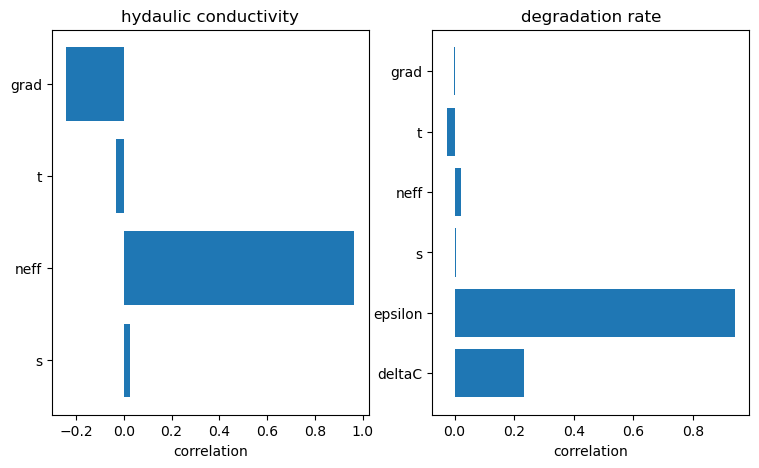

In [4]:
# [3] 
import matplotlib.pyplot as plt

labels = ['deltaC', 'epsilon', 's', 'neff', 't', 'grad']
plot_bio = correlation.iloc[0,2:len(correlation)]

labels_kf = ['s', 'neff', 't', 'grad']
plot_kf = correlation.iloc[1,4:len(correlation)]

fig = plt.figure(1, figsize=(9, 5))

ax = fig.add_subplot(1,2,1)
plt.barh(labels_kf, width=plot_kf)
plt.xlabel('correlation')
plt.title ('hydaulic conductivity')

ax1 = fig.add_subplot(1,2,2)
plt.barh(labels, width=plot_bio)
plt.xlabel('correlation')
plt.title ('degradation rate')
plt.show()


### Exercise 2: Sobol Indices

For more advanced sensitivity analysis we are going to employ the Python package `SALib` (https://salib.readthedocs.io/en/latest/index.html), which contains quite a few useful methods (e.g. Morris method, Sobol indices) and the required sampling strategies.

- First, download and install `SALib` in your virtual environment using the link above and 'pip install' in the command window (e.g. via the anaconda navigator). 

Now, we can use `SALib` to calculate the Sobol indices for the model inputs and outputs from Exercise 1 / last week. To do so, we need two functions in `SALib`.

- `SALib.sample.saltelli.sample()` to create the specific parameter input matrix required for calculating the model outputs as required for the Sobol indices, and 

- `SALib.analyze.sobol.analyze()` to actually calculate the Sobol indices. 

- First, create a Python dictionary that contains the information required to generate the input matrix (i.e. number of uncertain parameters, their names, corresponding min and max parameter values), using the following syntax: `dictionary = {'num_vars': number_uncertain_parameters, 'names': [Name1, Name2, ...], 'bounds':[[min1, max1], [min2, max2], ...]}`

- Then, use the dictionary to create the input-output-matrix: `matrix = SALib.sample.saltelli.sample(dictionary, n)`, with 'n' being the number of random samples to be created (e.g. 1000, to keep computational time low). 

- Last, inspect the generated array to see the logic behind the generated columns (see lecture slides). 

In [ ]:
# [4] 
# importing required packages
from SALib.sample.saltelli import sample

# create dictionary
problem = {
    'num_vars': 6,
    'names': ['deltaC', 'epsilon test', 's', 'neff', 't', 'grad'],
    'bounds': [[3.8, 4.8],
               [-3.2, -1.1],
               [415, 423],
               [0.12, 0.3],
               [3e8, 3.3e8],
               [1.3e-3, 1.6e-3]]
}

# create input matrix
X = sample(problem, 1000)

# inspect the created array
print(X)

[[ 3.80146484e+00 -2.40942383e+00  4.18582031e+02  2.07626953e-01
   3.16713867e+08  1.55327148e-03]
 [ 4.04169922e+00 -2.40942383e+00  4.18582031e+02  2.07626953e-01
   3.16713867e+08  1.55327148e-03]
 [ 3.80146484e+00 -1.96645508e+00  4.18582031e+02  2.07626953e-01
   3.16713867e+08  1.55327148e-03]
 ...
 [ 4.69892578e+00 -2.93647461e+00  4.18066406e+02  1.27119141e-01
   3.14223633e+08  1.48120117e-03]
 [ 4.69892578e+00 -2.93647461e+00  4.18066406e+02  1.27119141e-01
   3.25268555e+08  1.30043945e-03]
 [ 4.69892578e+00 -2.93647461e+00  4.18066406e+02  1.27119141e-01
   3.25268555e+08  1.48120117e-03]]


C:\Users\Kathrin_Menberg\AppData\Local\Temp\ipykernel_4952\3231100243.py:18: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X = sample(problem, 1000)
c:\ProgramData\anaconda3\envs\GDA1\Lib\site-packages\SALib\sample\saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


Now you can use the created parameter input matrix and the analytical equations from last week to calculate the corresponding model outputs. 

- Use a for-loop to calculate the hydraulic conductivity and degradation rate for each input parameter combination in the matrix from above. 

In [6]:
# [5]
# import packages
import numpy as np

# define number of runs (n), and zero-arrays for model outputs
n = len(X)
kf =np.zeros(n)
lambda_rate = np.zeros(n)

# use for loop to evaluate the analytical equations
for i in range(n):
    kf[i] = (X[i, 2]*X[i, 3])/(X[i, 4]*X[i, 5])
    lambda_rate[i] = -(X[i, 0]*kf[i]*X[i, 5])/(X[i, 1]*X[i, 2]*X[i, 3])

Y = lambda_rate*3600*24*365 # to get values as [1/a]

In order to calculate the Sobol Indices `SALib.analyze.sobol.analyze()` requires the dictionary with the input settings (not the matrix!) and the calculated model outputs. Adding the argument "print_to_console=True" prints the indices directly as outputs. 

- Create a variable (e.g. "Sobol") by calculating the Sobol Indices using `SALib.analyze.sobol.analyze()`. 

In [7]:
#[6]
# Packages laden
from SALib.analyze.sobol import analyze

# Sobol Indizes berechnen
Sobol = analyze(problem, Y, print_to_console=True)

                        ST       ST_conf
deltaC        4.760087e-02  5.368227e-03
epsilon test  9.665901e-01  6.322474e-02
s             2.028208e-31  3.061171e-32
neff          1.790486e-31  2.585046e-32
t             7.986443e-03  8.791197e-04
grad          1.346013e-31  2.273917e-32
                        S1       S1_conf
deltaC        4.253335e-02  1.663823e-02
epsilon test  9.614448e-01  8.281905e-02
s             6.881788e-18  3.692604e-17
neff         -2.216271e-17  3.290788e-17
t             7.911020e-03  7.602150e-03
grad          3.106997e-18  3.179495e-17
                                  S2       S2_conf
(deltaC, epsilon test)  5.430106e-03  3.667260e-02
(deltaC, s)             5.388039e-04  2.382102e-02
(deltaC, neff)          5.388039e-04  2.382102e-02
(deltaC, t)             5.826105e-04  2.434990e-02
(deltaC, grad)          5.388039e-04  2.382102e-02
(epsilon test, s)       8.253562e-05  1.099244e-01
(epsilon test, neff)    8.253562e-05  1.099244e-01
(epsilon test, t) 

- Now, visualise the total and first-order effects in a tornado plot, and compare first-order and total effects. Do they differ? And if not, why? 

- Also compare the Sobol Indices to the results from the contribution-to-variance analysis from above. 

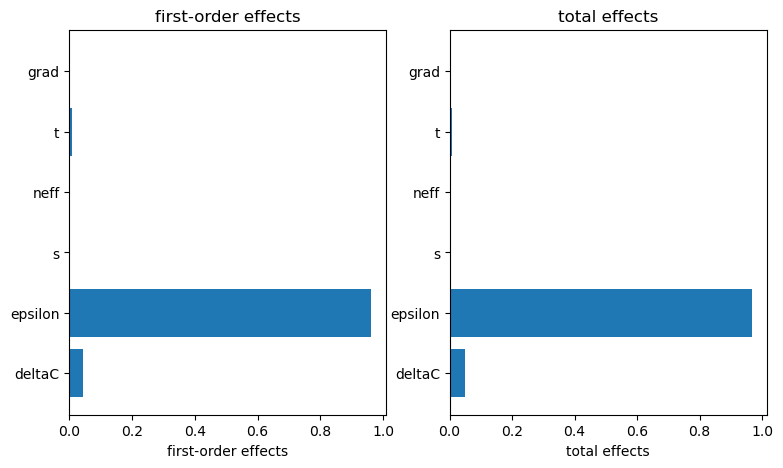

In [8]:
#[7]
import matplotlib.pyplot as plt

labels = ['deltaC', 'epsilon', 's', 'neff', 't', 'grad']

fig = plt.figure(1, figsize=(9, 5))

ax = fig.add_subplot(1,2,1)
plt.barh(labels, width=Sobol['S1'])
plt.xlabel('first-order effects')
plt.title ('first-order effects')

ax1 = fig.add_subplot(1,2,2)
plt.barh(labels, width=Sobol['ST'])
plt.xlabel('total effects')
plt.title ('total effects')
plt.show()

## END

### References:

Würth et al. (2021): Quantifying biodegradation rate constants of o-xylene by combining compound-specific isotope analysis and groundwater dating. Journal of Contaminant Hydrology, 238, 103757